# 1. Loading Data

In [60]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

Reduced= True

## 1.1 Functions

In [61]:
def print_size_var():
    print("Size of Variables")
    _vars = globals().items()
    for var, obj in _vars:
        print(var, sys.getsizeof(obj))
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def read_data():
    print('Reading files...')
    INPUT_DIR = 'data'
    calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
    sales_train_validation = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
    sell_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
    sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
    
    calendar = reduce_mem_usage(calendar)
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    sell_prices = reduce_mem_usage(sell_prices)
    sample_submission = reduce_mem_usage(sample_submission)

    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    print('Sample_submission has {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return calendar, sell_prices, sales_train_validation, sample_submission

def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null)+1, index=not_null.index)

    return df    

def melt(sales_train_validation, submission, reduced):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # get product table.
    product = sales_train_validation[id_columns]
    
    if reduced == True :
        sales_train_validation = sales_train_validation.drop([f"d_{d}" for d in range(1, 719)], axis = 1).melt( id_vars=id_columns, var_name="d", value_name="demand" )
    else:
        sales_train_validation = sales_train_validation.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales_train_validation = reduce_mem_usage(sales_train_validation, verbose=False)

    # separate test dataframes.
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + 28)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + 28)]

    # merge with product table
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id") # Adds info [item_id;dept_id;cat_id;store_id;state_id]
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")
    
    del product
    gc.collect()
    
    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales_train_validation["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales_train_validation, vals, evals], axis=0)
    del sales_train_validation, vals, evals

    # delete evaluation for now.
    data = data[data["part"] != "evaluation"]
    gc.collect()
    return data


def extract_d(df):
    return df["d"].str.extract(r"d_(\d+)").astype(np.int16)


def merge_calendar(data, calendar):
    #calendar = calendar.drop(["weekday", "wday", "month", "year", 'event_name_1', 'event_name_2'], axis=1)
    return data.merge(calendar, how="left", on="d").assign(d=extract_d)


def merge_sell_prices(data, sell_prices):
    return data.merge(sell_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

## 1.2 Load csv files to variables

In [62]:
#Load csv files to variables
calendar, sell_prices, sales_train_validation, sample_submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns
Sell prices has 6841121 rows and 4 columns
Sample_submission has 60980 rows and 29 columns


 ## 1.3 Encode categorical variables

In [63]:
calendar=reduce_mem_usage(calendar)

sales_train_validation = encode_categorical(
    sales_train_validation, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]
).pipe(reduce_mem_usage)

product2 = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

Mem. usage decreased to  0.12 Mb (0.0% reduction)
Mem. usage decreased to 94.01 Mb (1.0% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


## 1.4 Melt 

In [64]:
data = melt(sales_train_validation, sample_submission ,Reduced)
del sales_train_validation
del sample_submission

data = reduce_mem_usage(data)
data1 = data.loc[:len(data["part"])/2]
data2 = data.loc[len(data["part"])/2:]
del data
gc.collect()

print("Time-related data")
data1 = merge_calendar(data1, calendar)
data2 = merge_calendar(data2, calendar)
del calendar
gc.collect()

frames = [data1, data2]
data = pd.concat(frames)
del data1,data2,frames
gc.collect()

print("Price-related data")
data = merge_sell_prices(data, sell_prices)
del sell_prices
gc.collect()
data = reduce_mem_usage(data)

Mem. usage decreased to 1422.47 Mb (0.0% reduction)
Time-related data
Price-related data
Mem. usage decreased to 3307.25 Mb (0.0% reduction)


## 1.5 Combine SNAP

In [65]:
conditions = [
    (data['state_id'] == 1),
    (data['state_id'] == 2),
    (data['state_id'] == 3)]
choices = [data['snap_CA'], data['snap_TX'], data['snap_WI']]
data['snap'] = np.select(conditions, choices)
data =data.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1)
data = reduce_mem_usage(data)
del conditions, choices
gc.collect()

Mem. usage decreased to 3236.13 Mb (0.0% reduction)


20

## 1.6 Remove rows with price NA values

In [66]:
#Remove na values of sale_price
data.dropna(subset=['sell_price'],inplace=True)
data = reduce_mem_usage(data)

Mem. usage decreased to 2969.61 Mb (0.0% reduction)


## 1.7 Unstack & Combine Events

My alternative, focusing only on the events which happen in the predicted period.

In [67]:
events_predicted = data[(data['date'] > '2016-03-27')]['event_name_1'].unique()[1:]
for event in events_predicted:
    data[event] = (data['event_name_1'] == event)  |(data['event_name_2'] == event)
data.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], axis = 1, inplace = True)
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,sell_price,snap,Pesach End,OrthodoxEaster,Cinco De Mayo,Mother's day
1,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,3.970703,0,False,False,False,False
3,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,4.339844,0,False,False,False,False
4,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,719,1,train,2013-01-16,11251,Wednesday,5,1,2013,3.080078,0,False,False,False,False
5,HOBBIES_1_006_CA_1_validation,1443,4,2,1,1,719,3,train,2013-01-16,11251,Wednesday,5,1,2013,1.000000,0,False,False,False,False
6,HOBBIES_1_007_CA_1_validation,1444,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,7.878906,0,False,False,False,False


In [68]:
# data= pd.get_dummies(data, prefix="col1", prefix_sep='_', dummy_na=False, columns=["event_name_1","event_type_1"] )

# if Reduced ==True:
#     data =data.drop(['event_name_2', 'event_type_2'], axis=1)
# else:
#     data= pd.get_dummies(data, prefix="col2", prefix_sep='_', dummy_na=False, columns=["event_name_2","event_type_2"] )
#     data["col1_Cinco De Mayo"] = (data["col1_Cinco De Mayo"].astype('bool')  |  data["col2_Cinco De Mayo"].astype('bool') ).astype('int')
#     data["col1_Easter"] = (data["col1_Easter"].astype('bool')  |  data["col2_Easter"].astype('bool') ).astype('int')
#     data["col1_Father's day"] = (data["col1_Father's day"].astype('bool')  |  data["col2_Father's day"].astype('bool') ).astype('int')
#     data["col1_OrthodoxEaster"] = (data["col1_OrthodoxEaster"].astype('bool')  |  data["col2_OrthodoxEaster"].astype('bool') ).astype('int')
#     data["col1_Cultural"] = (data["col1_Cultural"].astype('bool')  |  data["col2_Cultural"].astype('bool') ).astype('int')
#     data["col1_Religious"] = (data["col1_Religious"].astype('bool')  |  data["col2_Religious"].astype('bool') ).astype('int')
#     data = data.drop(["col2_Cinco De Mayo","col2_Easter","col2_Father's day","col2_OrthodoxEaster","col2_Cultural","col2_Religious"], axis=1)

# data.columns = data.columns.str.replace(r'col1_', '')
# data = reduce_mem_usage(data)

## 1.8 Feature Engineering

In [69]:
data['woy']   = data['wm_yr_wk']%100
data['fyear'] = (data['wm_yr_wk']//100)%100
data['week_of_total'] = np.where( data['fyear'] <14, (data['woy'] + (data['fyear']- 11) * 52 ), ( 157+ data['woy']  + ((data['fyear']- 14) * 52)) ) 
data["is_weekend"] = data["wday"].isin([1, 2]).astype(np.int8)

# 2. Analysis

## 2.1 Find Item_Store with History < 1 year

Are some products out of production after a certain period ?

In [70]:
data['demand_active'] = (data['demand'] != 0)

product =data[data['demand_active']].groupby(['item_id','store_id'])['date'].first().reset_index()
product.rename(columns={"date": "start_date"}, inplace= True)
product['start_date'] = pd.to_datetime(product['start_date'])
product1=data[data['demand_active']].groupby(['item_id','store_id'])['date'].last().reset_index()
product1.rename(columns={"date": "end_date"}, inplace= True)
product1['end_date'] = pd.to_datetime(product1['end_date'])
product = product.merge(product1,how="outer", on=['item_id','store_id'])
product['days_active']=(product['end_date']- product['start_date']).dt.days
product['days_since_last'] = (pd.to_datetime('2016-04-24') - product['end_date']).dt.days

del product1
gc.collect()
new_item_store=product[product['days_active']<=365+28]

product['days_since_last'].value_counts()[:10]

0    14887
1     4846
2     2232
3     1269
4     1040
5      753
7      591
6      573
8      453
9      335
Name: days_since_last, dtype: int64

## 2.2 Plots

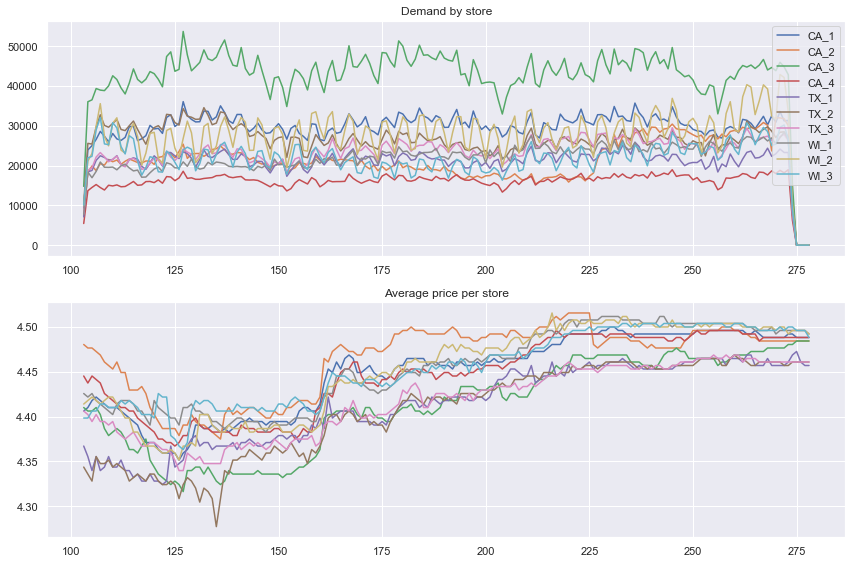

7299

In [71]:
demand_by_store = data.pivot_table(values='demand', index='store_id', columns='week_of_total', aggfunc = np.sum)
price_by_store = data.pivot_table(values='sell_price', index='store_id', columns='week_of_total')

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(demand_by_store.T)
plt.title('Demand by store')
plt.legend(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'])

plt.subplot(2,1,2)
plt.plot(price_by_store.T)
plt.title('Average price per store')

plt.tight_layout()
plt.show()

del demand_by_store,price_by_store
gc.collect()

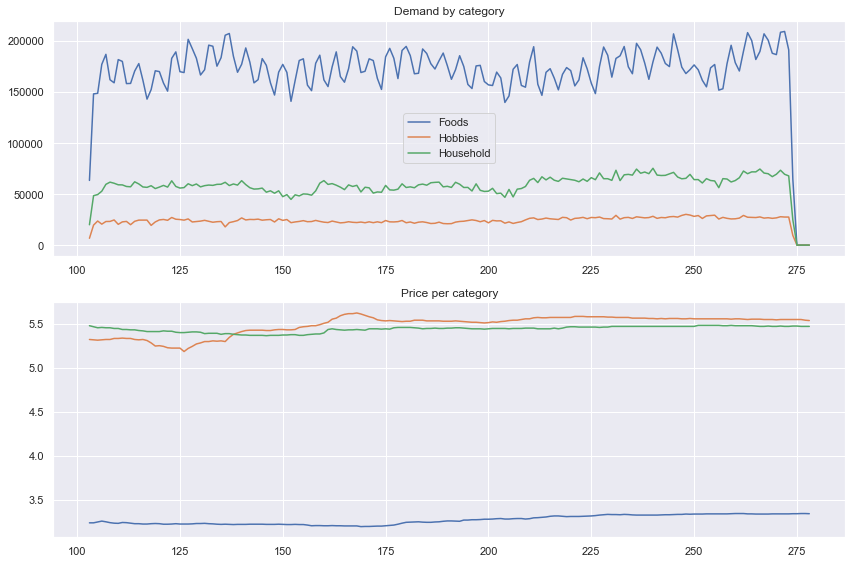

5401

In [72]:
demand_by_cat = data.pivot_table(values='demand', index='cat_id', columns='week_of_total', aggfunc = np.sum)
price_by_cat = data.pivot_table(values='sell_price', index='cat_id', columns='week_of_total')

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(demand_by_cat.T)
plt.title('Demand by category')
plt.legend(['Foods', 'Hobbies', 'Household'])

plt.subplot(2,1,2)
plt.plot(price_by_cat.T)
plt.title('Price per category')

plt.tight_layout()
plt.show()
del demand_by_cat,price_by_cat
gc.collect()

In [73]:
demand = data[['id','demand']].groupby('id').sum()['demand']
demand_recent = data[data['year'] >= 2015][['id','demand']].groupby('id').sum()['demand'] 
demand.max() - demand.quantile(0.99)


129921.45

The recent demand is particularly skewed (positively): the upper outliers are way more higher than the other rows.



In [74]:
demand.max() - demand_recent.quantile(0.99)


138375.22999999998

(array([15289.,  6618.,  3070.,  1570.,   988.,   621.,   446.,   342.,
          250.,   209.,   172.,   123.,   103.,    84.,    72.,    72.,
           48.,    45.,    28.,    35.]),
 array([   0. ,  271.2,  542.4,  813.6, 1084.8, 1356. , 1627.2, 1898.4,
        2169.6, 2440.8, 2712. , 2983.2, 3254.4, 3525.6, 3796.8, 4068. ,
        4339.2, 4610.4, 4881.6, 5152.8, 5424. ]),
 <a list of 20 Patch objects>)

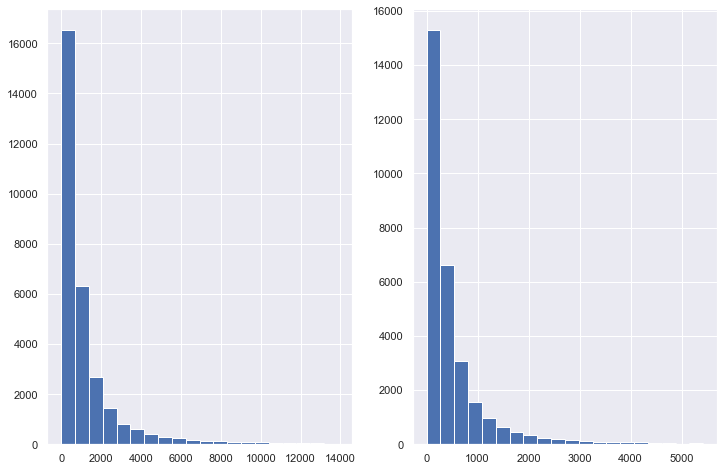

In [75]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.hist(demand.sort_values()[:int(0.99 * len(demand))], bins = 20)
plt.subplot(1,2,2)
plt.hist(demand_recent.sort_values()[:int(0.99 * len(demand_recent))], bins = 20)

For both the last year and the entire people, we see a large majority of products with less demand (approximately less than 2000 annual demand), and outliers with more than 40000 annual demand.



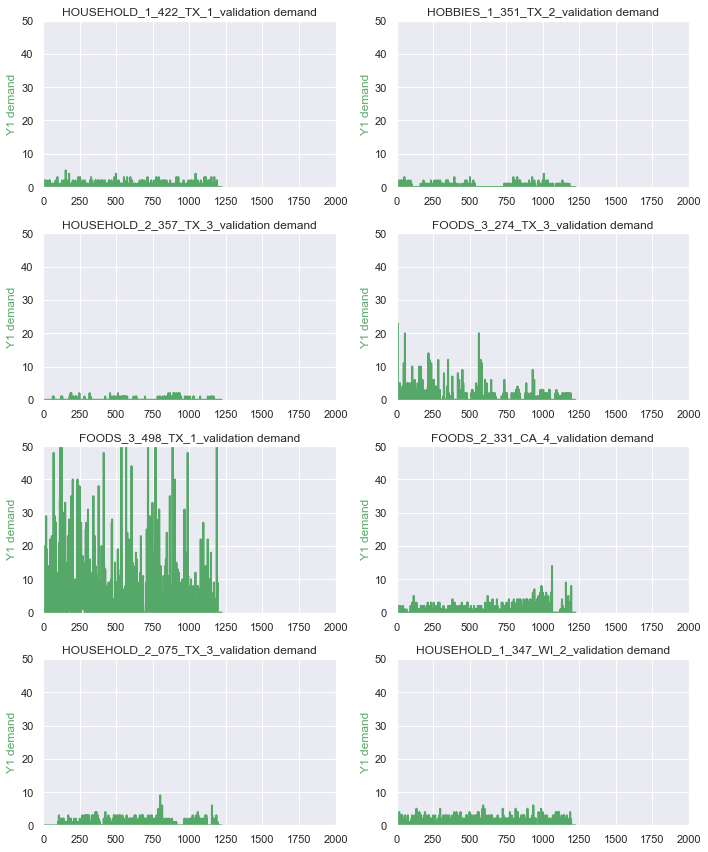

In [76]:
# Visualize individual demand
n = 8
random_id = data['id'].sample(n=8, random_state=1)
fig = plt.figure(figsize = (10,12))
for i in range(1, n+1):
    ax1=plt.subplot(4,2,i)
    ax1.plot(data[data['id'] == random_id.iloc[i - 1]]['demand'].values, 'g-',linewidth=2)
    ax1.set_ylabel('Y1 demand', color='g')
    ax1.set_ylim((0, 50))

  #  plt.plot
    plt.title('{} demand'.format(random_id.iloc[i - 1]))
    plt.xlim((0, 2000))
    
plt.tight_layout()
plt.show()

## 2.3 Price distribution:


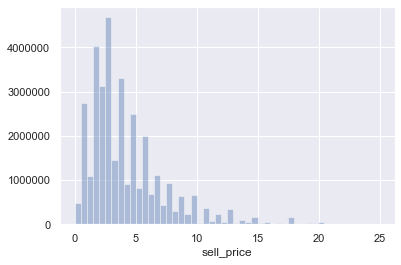

In [77]:
sns.distplot(data.loc[data['sell_price']<25, 'sell_price'], kde=False)

### Total sales behaviour depending on week/year


26002

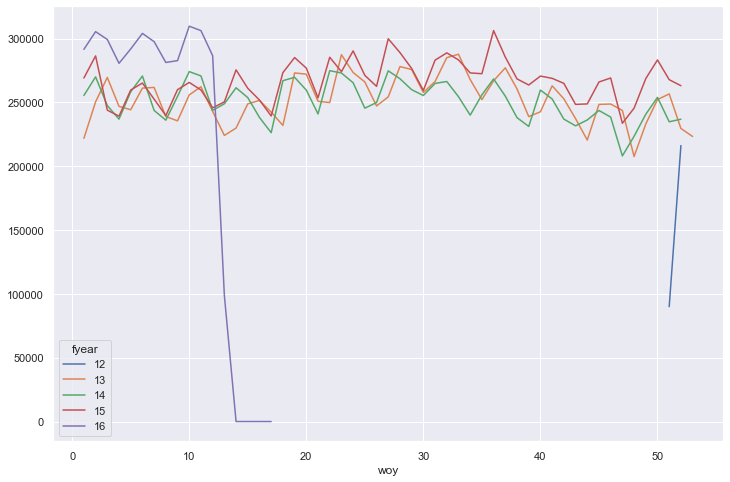

In [78]:
data2 = data.groupby(
    ['fyear','woy']).agg({'demand': np.sum}).reset_index().pivot(
    index='woy', columns='fyear', values='demand')
data2.plot(figsize=(12, 8))
del data2
gc.collect()

## 2.4 Add Item column:


In [79]:
data['items']=round(data['demand']/ data['sell_price'])

77% of daily item sales are zero :



In [80]:
data.loc[data['items']==0, :].shape[0] / data.shape[0]

0.7804327907271229

# Tests

In [81]:
sample = data[  data["id"]=="HOBBIES_1_004_CA_1_validation"]

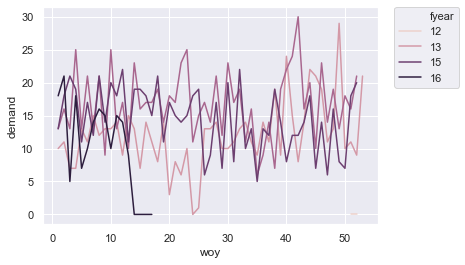

In [82]:
sns.lineplot(x='woy', y='demand' ,hue='fyear', data=sample.groupby(['woy','fyear'])['demand'].sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


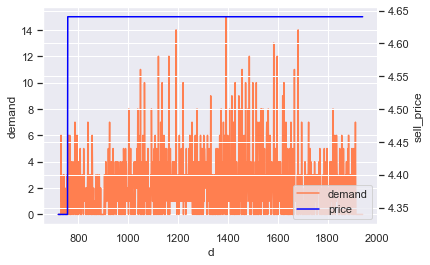

In [83]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.lineplot(x='d', y='demand' ,color="coral"  , data=sample, ax=ax)
sns.lineplot( x='d',y='sell_price',color="blue"   , data=sample ,  ax=ax2)  
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["demand", "price"])

## Seasonal decomposition:


<Figure size 1152x576 with 0 Axes>

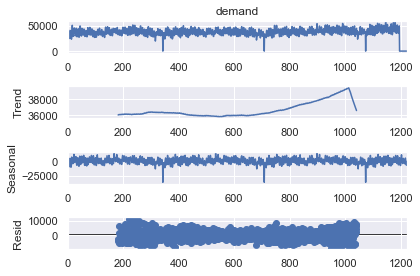

In [84]:
temp_sum = data.groupby( ['d'])['demand'].sum().reset_index()
plt.figure(figsize = (16, 8))
decomposition = sm.tsa.seasonal_decompose(temp_sum['demand'] , freq=365, model='additive')
fig = decomposition.plot()
plt.show()

In [85]:
for val in [28, 29, 30, 35]:
        data[f"shift_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(val))

for val in [7, 30 ]:
        data[f"rolling_mean_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

for val in [7, 30]:
        data[f"rolling_std_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
        
for val in [7, 30]:
        data[f"rolling_price_std_t{val}"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.shift(28).rolling(val).std())

In [86]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,sell_price,snap,Pesach End,OrthodoxEaster,Cinco De Mayo,Mother's day,woy,fyear,week_of_total,is_weekend,demand_active,items,shift_t28,shift_t29,shift_t30,shift_t35,rolling_mean_t7,rolling_mean_t30,rolling_std_t7,rolling_std_t30,rolling_price_std_t7,rolling_price_std_t30
1,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,3.970703,0,False,False,False,False,51,12,103,0,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,4.339844,0,False,False,False,False,51,12,103,0,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,719,1,train,2013-01-16,11251,Wednesday,5,1,2013,3.080078,0,False,False,False,False,51,12,103,0,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,HOBBIES_1_006_CA_1_validation,1443,4,2,1,1,719,3,train,2013-01-16,11251,Wednesday,5,1,2013,1.000000,0,False,False,False,False,51,12,103,0,True,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,HOBBIES_1_007_CA_1_validation,1444,4,2,1,1,719,0,train,2013-01-16,11251,Wednesday,5,1,2013,7.878906,0,False,False,False,False,51,12,103,0,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data["rolling_price_mean_t42"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(42).mean())
data['discount'] = data['sell_price'] < data['rolling_price_mean_t42']

In [88]:
data.loc[data['discount'] == True]

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,sell_price,snap,Pesach End,OrthodoxEaster,Cinco De Mayo,Mother's day,woy,fyear,week_of_total,is_weekend,demand_active,items,shift_t28,shift_t29,shift_t30,shift_t35,rolling_mean_t7,rolling_mean_t30,rolling_std_t7,rolling_std_t30,rolling_price_std_t7,rolling_price_std_t30,rolling_price_mean_t42,discount
1250097,HOBBIES_1_008_CA_1_validation,1445,4,2,1,1,760,5,train,2013-02-26,11305,Tuesday,4,2,2013,0.459961,0,False,False,False,False,5,13,109,0,True,11.0,4.0,33.0,3.0,0.0,6.857143,NaN,11.725024,NaN,0.000000,NaN,0.462891,True
1250108,HOBBIES_1_019_CA_1_validation,1456,4,2,1,1,760,4,train,2013-02-26,11305,Tuesday,4,2,2013,0.459961,0,False,False,False,False,5,13,109,0,True,9.0,0.0,24.0,6.0,0.0,7.714286,NaN,8.712334,NaN,0.000000,NaN,0.462891,True
1250137,HOBBIES_1_048_CA_1_validation,1485,4,2,1,1,760,17,train,2013-02-26,11305,Tuesday,4,2,2013,0.459961,0,False,False,False,False,5,13,109,0,True,37.0,0.0,4.0,21.0,0.0,10.571429,NaN,9.812528,NaN,0.000000,NaN,0.462891,True
1250186,HOBBIES_1_100_CA_1_validation,1534,4,2,1,1,760,0,train,2013-02-26,11305,Tuesday,4,2,2013,10.976562,0,False,False,False,False,5,13,109,0,False,0.0,0.0,1.0,1.0,0.0,0.285714,NaN,0.487950,NaN,0.267334,NaN,11.093750,True
1250229,HOBBIES_1_144_CA_1_validation,1577,4,2,1,1,760,1,train,2013-02-26,11305,Tuesday,4,2,2013,10.976562,0,False,False,False,False,5,13,109,0,True,0.0,0.0,0.0,1.0,0.0,0.428571,NaN,0.534522,NaN,0.000000,NaN,11.015625,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37289176,FOODS_3_732_WI_3_validation,1343,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,1.940430,0,False,False,False,False,17,16,278,1,False,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.408201e-08,0.000000,0.0,2.048828,True
37289188,FOODS_3_745_WI_3_validation,1355,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,1.980469,0,False,False,False,False,17,16,278,1,False,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.410938e-08,0.000000,0.0,2.103516,True
37289197,FOODS_3_754_WI_3_validation,1364,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,5.980469,0,False,False,False,False,17,16,278,1,False,0.0,0.0,0.0,1.0,0.0,0.142857,0.200000,0.377964,4.068381e-01,0.000000,0.0,6.183594,True
37289225,FOODS_3_782_WI_3_validation,1392,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,2.500000,0,False,False,False,False,17,16,278,1,False,0.0,9.0,6.0,5.0,5.0,4.428571,3.733333,2.636737,2.753472e+00,0.000000,0.0,2.582031,True


# 3.Fit & Predict

In [89]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.tail()

Data usage: 4.995864062 GB


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,sell_price,snap,Pesach End,OrthodoxEaster,Cinco De Mayo,Mother's day,woy,fyear,week_of_total,is_weekend,demand_active,items,shift_t28,shift_t29,shift_t30,shift_t35,rolling_mean_t7,rolling_mean_t30,rolling_std_t7,rolling_std_t30,rolling_price_std_t7,rolling_price_std_t30,rolling_price_mean_t42,discount
37289266,FOODS_3_823_WI_3_validation,1433,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,2.980469,0,False,False,False,False,17,16,278,1,False,0.0,1.0,0.0,0.0,0.0,0.285714,0.200000,0.487950,0.550861,0.0,0.000000,2.980469,False
37289267,FOODS_3_824_WI_3_validation,1434,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,2.480469,0,False,False,False,False,17,16,278,1,False,0.0,0.0,1.0,0.0,0.0,0.142857,0.300000,0.377964,0.534983,0.0,0.206665,2.480469,False
37289268,FOODS_3_825_WI_3_validation,1435,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,3.980469,0,False,False,False,False,17,16,278,1,False,0.0,0.0,1.0,0.0,0.0,0.571429,0.866667,0.786796,1.136642,0.0,0.000000,3.980469,False
37289269,FOODS_3_826_WI_3_validation,1436,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,1.280273,0,False,False,False,False,17,16,278,1,False,0.0,3.0,1.0,3.0,1.0,1.142857,1.066667,1.345185,1.172481,0.0,0.000000,1.280273,False
37289270,FOODS_3_827_WI_3_validation,1437,3,1,10,3,1941,0,validation,2016-05-22,11617,Sunday,2,5,2016,1.000000,0,False,False,False,False,17,16,278,1,False,0.0,0.0,0.0,0.0,0.0,0.000000,1.166667,0.000000,1.821014,0.0,0.000000,1.000000,False


In [90]:
# data.columns
features = ["item_id", "dept_id", "cat_id", "store_id", "state_id",\
            "snap", "sell_price", \
    # time features.
            "fyear", "month", "wday","woy",  'week_of_total', \
    # event-related features
            'Pesach End', 'OrthodoxEaster', 'Cinco De Mayo', "Mother's day", \
    # price-related
            'discount', \
    # product-related features
#             'demand_active', \
    # demand-related features 
            'shift_t28', 'shift_t35', 'rolling_mean_t30', 'rolling_std_t30', \
    # Predicted features
            'id', 'date', 'demand']

# + rolling_means/std, price change, rolling_price, ...

## Weights 

In [91]:
#temp=data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')] # sales over last 28 days 
#temp=temp[["item_id","dept_id","cat_id","store_id","state_id","demand"]]

#wlevel12=temp.groupby(['item_id', 'store_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel11=temp.groupby(['state_id', 'store_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel10=temp.groupby(['item_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel9=temp.groupby(['store_id', 'cat_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel8=temp.groupby(['store_id', 'dept_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel7=temp.groupby(['state_id', 'cat_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel6=temp.groupby(['state_id', 'dept_id']).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel5=temp.groupby(['cat_id' ]).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel4=temp.groupby(['dept_id' ]).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel3=temp.groupby(['store_id' ]).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel2=temp.groupby(['state_id' ]).agg({'demand': 'sum'}).apply(lambda x:100 * x / float(x.sum())).reset_index()
#wlevel1=1

In [92]:
print_size_var()

Size of Variables
__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 920
_oh 1176
_dh 64
In 920
Out 1176
get_ipython 64
exit 48
quit 48
_ 1991
__ 254255210
___ 1976
_i 1558
_ii 699
_iii 129
_i1 666
sys 72
gc 72
os 72
warnings 72
pickle 72
_i2 666
sm 72
rcParams 9328
time 72
pd 72
register_matplotlib_converters 136
np 72
plt 72
_i3 666
sns 72
lgb 72
mean_squared_error 136
LabelEncoder 1064
preprocessing 72
metrics 72
Reduced 28
_i4 5656
print_size_var 136
reduce_mem_usage 136
read_data 136
display_missing 136
encode_categorical 136
melt 136
extract_d 136
merge_calendar 136
merge_sell_prices 136
_i5 156
_i6 5628
_i7 156
_i8 454
product2 3041216
_i9 644
_i10 384
_10 28
_i11 158
_i12 361
events_predicted 96
event 61
_12 1576
_i13 1407
_i14 341
_i15 906
_15 176
_i16 622
_16 28
_i17 556
_17 28
_i18 237
_18 32
_i19 92
_19 32
_i20 265
_20 64
_i21 513
n 28
random_id 770
fig 48
i 28
ax1 48
_i22 119
_22 48
_i23 238
_23 28
_i24 104
_i25 103
_25 24
_

In [93]:
del product ,new_item_store ,demand ,demand_recent, sample, temp_sum 
gc.collect()


20

In [94]:
sales_train_validation = pd.read_csv('data/sales_train_validation.csv')

sales_train_validation = encode_categorical(
    sales_train_validation, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

product2 = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

Mem. usage decreased to 94.01 Mb (78.9% reduction)


In [95]:
from scipy.sparse import csr_matrix

weight_mat = np.c_[np.ones([30490,1]).astype(np.int8), # level 1
                   pd.get_dummies(product2.state_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.store_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.state_id.astype(str) + product2.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.state_id.astype(str) + product2.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.store_id.astype(str) + product2.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.store_id.astype(str) + product2.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.item_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product2.state_id.astype(str) + product2.item_id.astype(str),drop_first=False).astype('int8').values,
                   np.identity(30490).astype(np.int8) #item :level 12
                   ].T

weight_mat_csr = csr_matrix(weight_mat)
del weight_mat
gc.collect()


20

In [96]:
def weight_calc(data,product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount

    sales_train_val = pd.read_csv('data/sales_train_validation.csv')

    d_name = ['d_' + str(i+1) for i in range(1913)]

    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item  
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))

    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))<1

    sales_train_val = np.where(flag,np.nan,sales_train_val)

    # denominator of RMSSE / RMSSE 
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no)

    # calculate the sales amount for each item/level
    df_tmp = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp[product2.id].values
    
    weight2 = weight_mat_csr * df_tmp 

    weight2 = weight2/np.sum(weight2)

    del sales_train_val,df_tmp,flag,start_no
    gc.collect()
    
    return weight1, weight2


In [97]:
weight1, weight2 = weight_calc(data,product2)


In [98]:
def wrmsse(preds, data):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values 
    y_true = data.get_label()
    
    y_true = y_true[-(30490 * 28):]
    preds = preds[-(30490 * 28):]
    # number of columns
    num_col = 28
    
    # reshape data to original array((30490*num_col,1)->(30490, num_col) ) 
    reshaped_preds = preds.reshape(num_col, 30490).T
    reshaped_true = y_true.reshape(num_col, 30490).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

In [100]:
# Date limitation to 2014 and after (for now)
x_train = data[(data['date'] <= '2016-03-27') & (data['date'] >= '2014-01-01')][features]
y_train = data[(data['date'] <= '2016-03-27') & (data['date'] >= '2014-01-01')]['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')][features]
y_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]['demand']
x_test = data[(data['date'] > '2016-04-24')][features]
#del data
gc.collect()

NameError: name 'data' is not defined

In [ ]:
params = {
        'metric': 'custom',
        'objective': 'regression',
        'min_data_in_leaf': 200,
        'n_jobs': -1,
        'seed': 20,
        'learning_rate': 0.05,
        'alpha': 0.1,
        'lambda': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'colsample_bytree': 0.77,
        'seed': 1}

train_set = lgb.Dataset(x_train.drop(['id', 'date', 'demand'], axis = 1), y_train)
val_set = lgb.Dataset(x_val.drop(['id', 'date', 'demand'], axis = 1), y_val)
del x_train, y_train
gc.collect()

In [50]:
reduce_mem_usage(x_val)
reduce_mem_usage(x_test)
gc.collect()

Mem. usage decreased to 43.97 Mb (32.5% reduction)
Mem. usage decreased to 43.15 Mb (33.8% reduction)


0

In [51]:
# previous score: [455]	training's wrmsse: 0.628521	valid_1's wrmsse: 0.568253
lgb_model = lgb.train(params, train_set, num_boost_round = 2000, early_stopping_rounds = 100, valid_sets = [train_set, val_set],
    verbose_eval = 100 , feval= wrmsse)

Training until validation scores don't improve for 100 rounds
[100]	training's wrmsse: 0.692778	valid_1's wrmsse: 0.617505
[200]	training's wrmsse: 0.649637	valid_1's wrmsse: 0.574973
[300]	training's wrmsse: 0.639689	valid_1's wrmsse: 0.569681
[400]	training's wrmsse: 0.629989	valid_1's wrmsse: 0.569527
[500]	training's wrmsse: 0.621863	valid_1's wrmsse: 0.570527
Early stopping, best iteration is:
[455]	training's wrmsse: 0.628521	valid_1's wrmsse: 0.568253


In [52]:
list1 = [ele for ele in features if ele not in ('id', 'date', 'demand')] 
val_pred = lgb_model.predict(x_val[list1], num_iteration=lgb_model.best_iteration)
val_score = np.sqrt(mean_squared_error(val_pred, y_val))
print(f'Our val rmse score is {val_score}')
y_pred = lgb_model.predict(x_test[list1], num_iteration=lgb_model.best_iteration)
x_test['demand'] = y_pred
predictions = x_test[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

INPUT_DIR = 'data'
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
    
evaluation_rows = [row for row in sample_submission['id'] if 'evaluation' in row] 
evaluation = sample_submission[sample_submission['id'].isin(evaluation_rows)]

validation = sample_submission[['id']].merge(predictions, on = 'id')

final = pd.concat([validation, evaluation])
final.to_csv('sample_submission.csv', index = False)

Our val rmse score is 2.173750419948014


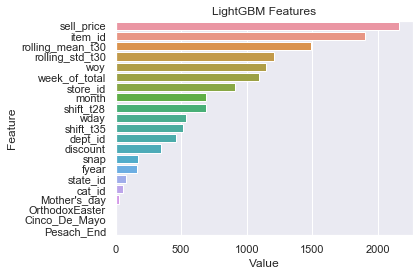

In [53]:
feature_importance = pd.DataFrame({"Value": lgb_model.feature_importance(), "Feature": lgb_model.feature_name()})
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [58]:
final = pd.concat([validation, evaluation])

#for i in range(1,29):
#    final['F'+str(i)] *= 1.05
    
final.to_csv('submission_4.csv', index=False) 